### Notes

Just did a quick first pass through of this paper. It gives a heavily theory based justification for L2 regularization / weight decay. Honestly my linear algebra and math knowledge isn't up to par for this one, still grinding on Math Academy and levelling that part of my knowledge up, but I'll still give it a shot to try to get the jist / and I'll still add a weight decay to some previous code I've written. Although the problem it solves I never really had, where my network overfits quite badly. Maybe I'll make one overfit slightly and then see how it goes.

#### Overview

At this point it's already been established that adding a simple penalty term to the cost function, that increases the cost if the weights become large, has a positive effect on model overfitting and helps models generalize better.

This is of the form

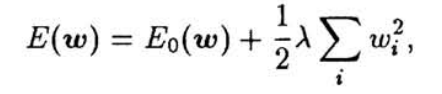

Which adds a small "gravity" to the weight updates such that the weight update is proportional to the following:

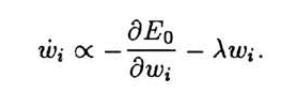

The authors showed that the reason that this works so well is for two reasons:

1. If there's not a lot of data and a decent amount of weights, then there are many different weight configurations that perfectly fit to the data. Weight decay tells the model to choose the "simplest" one, the one with the smallest weight magnitudes. If we believe that the world is a nice and simple place, and that if we can find a simple rule that explains why data has the properties that it does and that that is good, then this will help us get there.

2. It helps to handle noise / the unreliable teacher problem. If there is noise in the data, a powerful network may try to fit the noise, which will hurt it's generalization. Weight decay provides a way to dampen the networks response, preventing it from overfitting to that noise.

The authors show all this with a simple linear perceptron model where the math is nice (but still a bit complex for me).

#### The general gist

They show that with weight decay in directions where the data provides no important information, we set the weights to 0.

They show that if the data has noise that adding weight decay acts as a damping mechanism.

But what is the right $\lambda$ to set the decay to? They show that it is the noise power over the signal power. The right lambda depends on the signal to noise ratio of the problem. For data that has strong signal and little noise you want a small lambda (would this correspond to good curated data?), for data that has weak signal you want a larger lambda. Having a larger lambda makes the network more "skeptical" of learning features that require large weights, assuming that those are more likely to be noise rather than signal.

In [1]:
# overfit my MLP on a small amount of data, then see generalization results, then add weight penalty and see the results of that

In [134]:
# reimporting my previous MLP code

# bring in mnist (copy pasted from other notebook so it uses tf but I want it to be an exact copy of what I did before)
from tensorflow.keras.datasets import mnist
import torch

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
print("done")

done


In [135]:
import random
import math

class Fully_Connected_Layer():
    def __init__(self, nin, nout, nonlinearity):
        self.w = torch.randn(nin, nout)
        self.w.mul_(math.sqrt(2.0 / nin)) 
        self.w.requires_grad_()                 
        self.b = torch.randn(nout, requires_grad=True)
        self.nonlinearity = nonlinearity

    def __call__(self, x):
        act = (x @ self.w) + self.b
        if(self.nonlinearity):
            return torch.relu(act)
        return act

    def parameters(self):
        return [self.w, self.b]

class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Fully_Connected_Layer(sz[i], sz[i+1], True) for i in range(len(nouts)- 1)]
        self.layers.append(Fully_Connected_Layer(sz[-2], sz[-1], False))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

            

In [136]:
import random

lossi = []
mnist_mlp = MLP(28*28, [512, 512, 10])
learning_rate = 0.001
epochs = 100
examples_per_epoch = 500

print_reset_error_interval = 250
cumulative_error = 0
count = 0

for epoch in range(epochs):
    cumulative_error = 0
    for i in range(examples_per_epoch):
        flattened = torch.flatten(x_train[i])
        out = mnist_mlp(flattened)
        loss = loss_individual(out, y_train[i].item())
        cumulative_error += loss.item()
        loss.backward()
        count += 1
        with torch.no_grad():
            for p in mnist_mlp.parameters():
                p -= learning_rate * p.grad
                p.grad.zero_()
        if(i % print_reset_error_interval == 0 and i != 0):
            lossi.append(cumulative_error / print_reset_error_interval)
            cumulative_error = 0


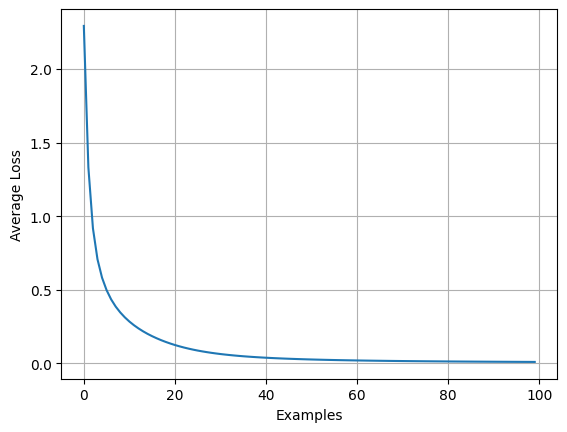

In [137]:
import matplotlib.pyplot as plt

plt.plot(lossi)
plt.xlabel('Examples')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

In [138]:
# print accuracy on train set

correct_predictions = 0
total_examples = 500
for i in range(total_examples):
    flattened = torch.flatten(x_train[i])
    out = mnist_mlp(flattened)

    predicted_class = torch.argmax(out).item()

    true_label = y_train[i].item()

    if predicted_class == true_label:
        correct_predictions += 1

accuracy_percentage = (correct_predictions / total_examples) * 100
print(f"Accuracy on entire train set: {accuracy_percentage:.2f}%")

Accuracy on entire train set: 100.00%


In [139]:
# print accuracy on test set

correct_predictions = 0
total_examples = len(x_test)
for i in range(total_examples):
    flattened = torch.flatten(x_test[i])
    out = mnist_mlp(flattened)

    predicted_class = torch.argmax(out).item()

    true_label = y_test[i].item()

    if predicted_class == true_label:
        correct_predictions += 1

accuracy_percentage = (correct_predictions / total_examples) * 100
print(f"Accuracy on entire train set: {accuracy_percentage:.2f}%")

Accuracy on entire train set: 84.02%


Wait lol it still did pretty good on the train set. Anyway though let's now activate regularization and see how that works out.

In [151]:
import random

lossi = []
mnist_mlp = MLP(28*28, [512, 512, 10])
learning_rate = 0.001
epochs = 45
examples_per_epoch = 500
lambda_val = 0.0001

print_reset_error_interval = 250
cumulative_error = 0
count = 0

for epoch in range(epochs):
    cumulative_error = 0
    for i in range(examples_per_epoch):
        flattened = torch.flatten(x_train[i])
        out = mnist_mlp(flattened)
        weights_sum = None
        for p in mnist_mlp.parameters():
            if(p.dim() > 1):
                square = torch.square(p)
                sum = square.sum()
                weights_sum = sum if weights_sum is None else weights_sum + sum
        loss = loss_individual(out, y_train[i].item()) + lambda_val * weights_sum
        loss.backward()
        with torch.no_grad():
            cumulative_error += loss_individual(out, y_train[i].item()).item()
        count += 1
        with torch.no_grad():
            for p in mnist_mlp.parameters():
                p -= learning_rate * p.grad
                p.grad.zero_()
        if(i % print_reset_error_interval == 0 and i != 0):
            lossi.append(cumulative_error / print_reset_error_interval)
            cumulative_error = 0
print("done")

done


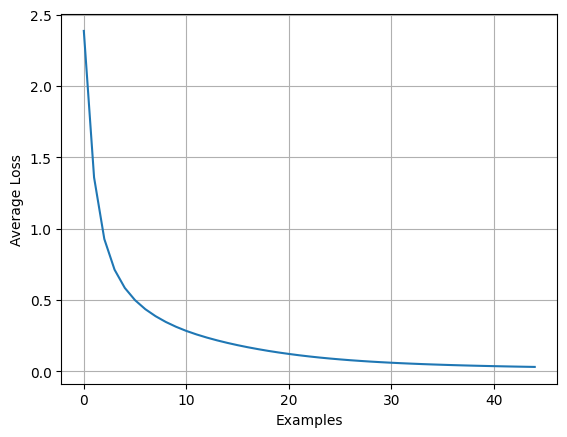

In [148]:
import matplotlib.pyplot as plt

plt.plot(lossi)
plt.xlabel('Examples')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

In [149]:
# print accuracy on train set

correct_predictions = 0
total_examples = 500
for i in range(total_examples):
    flattened = torch.flatten(x_train[i])
    out = mnist_mlp(flattened)

    predicted_class = torch.argmax(out).item()

    true_label = y_train[i].item()

    if predicted_class == true_label:
        correct_predictions += 1

accuracy_percentage = (correct_predictions / total_examples) * 100
print(f"Accuracy on entire train set: {accuracy_percentage:.2f}%")

Accuracy on entire train set: 100.00%


In [150]:
# print accuracy on test set

correct_predictions = 0
total_examples = len(x_test)
for i in range(total_examples):
    flattened = torch.flatten(x_test[i])
    out = mnist_mlp(flattened)

    predicted_class = torch.argmax(out).item()

    true_label = y_test[i].item()

    if predicted_class == true_label:
        correct_predictions += 1

accuracy_percentage = (correct_predictions / total_examples) * 100
print(f"Accuracy on entire train set: {accuracy_percentage:.2f}%")

Accuracy on entire train set: 84.41%
